In [2]:
import os
os.chdir('../../')
os.getcwd()

'/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing'

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from v2.model import Trading
from v2.strategy.indicators.smma import SMMA
from v2.strategy.indicators.stochastic_oscillator import StochasticOscillator
from v2.strategy.indicators.bollinger_bands import BollingerBands
from v2.strategy.indicators.rsi import RSI
from v2.strategy.indicators.macd import MACD
from v2.strategy.indicators.param import Param
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

In [7]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())

In [8]:
datasets = model.dfs
appended_dataset = pd.DataFrame()
for d in datasets:
    training_set = d[0]
    training_set['trough'] = training_set.iloc[argrelextrema(training_set.close.values, np.less_equal, order=480)[0]]['close']
    training_set['peak'] = training_set.iloc[argrelextrema(training_set.close.values, np.greater_equal, order=480)[0]]['close']
    ema_fast = Param(5, 10000, 0, 'ema_fast', 60)
    ema_slow= Param(6, 10001, 0, 'ema_slow', 120)
    signal = Param(5, 10001, 0, 'signal', 90)
    macd_ = MACD(_params=[ema_fast, ema_slow, signal], _name='macd')
    macd_.genData(training_set, gen_new_values=False)
    boll_period = Param(5, 10000, 0, 'period', 90)
    boll_bands = BollingerBands(_params=[boll_period], _name='bollinger_bands')
    boll_bands.genData(training_set, gen_new_values=False)
    stoch_highlow = Param(5, 10000, 0, 'highlow_range', 90.0)
    stoch_k = Param(5, 10000, 0, 'k_period', 270.0)
    stoch_oscillator = StochasticOscillator(_params=[stoch_highlow, stoch_k], _name='stochastic_oscillator')
    stoch_oscillator.genData(training_set, gen_new_values=False)
    rsi_period = Param(5, 10000, 0, 'period', 90.0)
    rsi_ = RSI(_params=[rsi_period], _name='rsi')
    rsi_.genData(training_set, gen_new_values=False)
    smma_period = Param(5, 10000, 0, 'period', 90.0)
    smma_ = SMMA(_params=[smma_period], _name='smma')
    smma_.genData(training_set, gen_new_values=False)
    training_set[['trough', 'peak']] = training_set[['trough', 'peak']].fillna(0)
    training_set['slope'] = (training_set['close'].rolling(window=30).max() - training_set['close'].rolling(window=30).min()) / training_set['close'].rolling(window=30).max()
    training_set = training_set.dropna()
    appended_dataset = appended_dataset.append(training_set)

In [1]:
appended_dataset.head()

NameError: name 'appended_dataset' is not defined

In [92]:
trough_input_data = appended_dataset[['stosc_k', 'slope', 'macd_diff', 'rsi', 'ema_fast', 'ema_slow']]
appended_dataset['trough'] = appended_dataset['trough'].gt(0).astype(int)
is_trough = appended_dataset[['trough']]

raw_x_train_df, raw_x_test_df, raw_y_train_df, raw_y_test_df = train_test_split(trough_input_data, is_trough, test_size=0.2, shuffle=False)

classify_all = np.array(trough_input_data)
trough_all = np.array(is_trough)
classify_X_train = np.array(raw_x_train_df)
classify_X_test = np.array(raw_x_test_df)
classify_y_train = np.array(raw_y_train_df)
classify_y_test = np.array(raw_y_test_df)

In [26]:
#random forresti(random_state=69420, max_features=None,       criterion='gini', n_estimators=200, n_jobs=-1, min_samples_leaf=1)
    rand_forest.fit(classify_X_trainassify_y_train)
    print("RF with {} trees had scor: {}".format(tree, rand_forest.score(classify_X_test, classify_y_test)))
    print("Number of troughs found: format(sum(rand_forest.predict(classify_X_test))))

hi
<ipython-input-26-2ec5231ae399>:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KeyboardInterrupt: 

In [33]:
#random forrest
trees = [3, 5, 10, 25, 50, 75, 100]
for tree in trees:
    temp_rf = RandomForestClassifier(random_state=69420, max_features=None,       criterion='gini', n_estimators=tree, n_jobs=-1, min_samples_leaf=1)
    temp_rf.fit(classify_X_train, classify_y_train.ravel())
    print("RF with {} trees had score of: {}".format(tree, temp_rf.score(classify_X_test, classify_y_test)))
    print("Number of troughs found: {}".format(sum(temp_rf.predict(classify_X_test))))

RF with 3 trees had score of: 0.9989092809091503
Number of troughs found: 103
RF with 5 trees had score of: 0.9990529684540527
Number of troughs found: 61
RF with 10 trees had score of: 0.9991705309907909
Number of troughs found: 17
RF with 25 trees had score of: 0.9992097185030371
Number of troughs found: 3
RF with 50 trees had score of: 0.9992097185030371
Number of troughs found: 5
RF with 75 trees had score of: 0.9992129841290576
Number of troughs found: 4
RF with 100 trees had score of: 0.9992129841290576
Number of troughs found: 4


In [37]:
#grad boost
depths = [1,2,3,4,5,7,9,10]
for depth in depths:
    boost = XGBClassifier(subsample = 0.7, max_depth = depth)
    boost.fit(classify_X_train, classify_y_train)
    print("Boost with depth: {} had this score: {}".format(depth, boost.score(classify_X_test, classify_y_test)))
    print("Number of troughs classifierd: {}".format(sum(boost.predict(boost_X_classify_X_test

Boost with depth: 1 had this score: 0.9985631245509764
Number of troughs classifierd: 225
Boost with depth: 2 had this score: 0.998572921429038
Number of troughs classifierd: 216
Boost with depth: 3 had this score: 0.9986643589576122
Number of troughs classifierd: 186
Boost with depth: 4 had this score: 0.9987525308601659
Number of troughs classifierd: 157
Boost with depth: 5 had this score: 0.9987525308601659
Number of troughs classifierd: 159
Boost with depth: 7 had this score: 0.9987557964861864
Number of troughs classifierd: 158
Boost with depth: 9 had this score: 0.9987525308601659
Number of troughs classifierd: 157
Boost with depth: 10 had this score: 0.998772124616289
Number of troughs classifierd: 153


In [93]:
rand_forest = RandomForestClassifier(random_state=69420, max_features=None,       criterion='gini', n_estimators=3, n_jobs=-1, min_samples_leaf=1)
rand_forest.fit(classify_X_train, classify_y_train)

train_pred = rand_forest.predict_proba(classify_X_train)[:,1]
test_pred = rand_forest.predict_proba(classify_X_test)[:,1]
train_trough = rand_forest.predict(classify_X_train)
test_trough = rand_forest.predict(classify_X_test)

raw_x_train_df["RF_prediction"] = train_pred
raw_x_test_df["RF_prediction"] = test_pred
raw_x_train_df["RF_trough"] = train_trough
raw_x_test_df["RF_trough"] = test_trough

<ipython-input-93-c77996563c85>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

<ipython-input-93-c77996563c85>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-c77996563c85>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-c77996563c85>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [94]:
dfs = [raw_x_train_df, raw_x_test_df]

boost_all = np.array(pd.concat(dfs).values)
boost_X_train = np.array(raw_x_train_df)
boost_X_test = np.array(raw_x_test_df)

In [81]:
#using rf data inside gradient boost
depths = [0.1, 0.2, 0.3, 0.4, 0.5]
print(depths)
for depth in depths:
    temp_boost = XGBClassifier(gamma= depth, booster="gbtree", n_estimators=100, n_jobs=-1, scale_pos_weight=1223, subsample = 0.7, max_depth = 5)
    temp_boost.fit(boost_X_train, classify_y_train.ravel())
    print("Boost with estiators: {} had this score: {}".format(depth, temp_boost.score(boost_X_test, classify_y_test)))
    print("Number of troughs classifierd: {}".format(sum(temp_boost.predict(boost_X_test))))

[0.1, 0.2, 0.3, 0.4, 0.5]
Boost with estiators: 0.1 had this score: 0.9983247338514794
Number of troughs classifierd: 300
Boost with estiators: 0.2 had this score: 0.9983051400953563
Number of troughs classifierd: 306
Boost with estiators: 0.3 had this score: 0.9983900463718894
Number of troughs classifierd: 280
Boost with estiators: 0.4 had this score: 0.9984390307621971
Number of troughs classifierd: 257
Boost with estiators: 0.5 had this score: 0.99839331199791
Number of troughs classifierd: 275


In [65]:
1/((sum(classify_y_test) + sum(classify_y_train))/(len(classify_y_test) + len(classify_y_train)))

array([1223.89768185])

In [95]:
official_boost = XGBClassifier(gamma= 0.3, booster="gbtree", n_estimators=100, n_jobs=-1, scale_pos_weight=1223, subsample = 0.7, max_depth = 5)
official_boost.fit(boost_all, trough_all.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1223, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

<ipython-input-106-af9d4256411b>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-af9d4256411b>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-af9d4256411b>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-106-

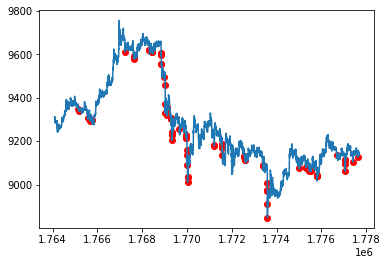

In [106]:
trading = Trading(load_config())
datasets = trading.dfs
test_data = datasets[0][0]

macd_.genData(test_data, gen_new_values=False)

boll_bands.genData(test_data, gen_new_values=False)

stoch_oscillator.genData(test_data, gen_new_values=False)

rsi_.genData(test_data, gen_new_values=False)
test_data['slope'] = (test_data['close'].rolling(window=10).max() - test_data['close'].rolling(window=10).min()) / test_data['close'].rolling(window=10).max()
test_data = test_data.dropna()

test_data["RF_probability"] = rand_forest.predict_proba(test_data[["stosc_k", 'slope', 'macd_diff', 'rsi', 'ema_fast', 'ema_slow']].values)[:,1]
test_data["RF_trough"] = rand_forest.predict(test_data[["stosc_k", 'slope', 'macd_diff', 'rsi', 'ema_fast', 'ema_slow']].values)

new_input_data_trough = test_data[['stosc_k', 'slope', 'macd_diff', 'rsi', 'ema_fast', 'ema_slow', 'RF_probability', 'RF_trough']].values
predictions = official_boost.predict(new_input_data_trough)

test_data['predictions_trough'] = predictions
def insert_predictions(close, prediction):
    if prediction > 0.95:
        return close
    else:
        return None
test_data['predictions_trough'] = test_data.apply(lambda row: insert_predictions(row['close'], row['predictions_trough']), axis=1)
plt.scatter(test_data.index, test_data['predictions_trough'], c='r')
# axes = plt.gca()
# axes.set_ylim([79,81])
plt.plot(test_data.index, test_data['close'])
plt.show()

In [111]:
pickle.dump(official_boost, open('boost_trough_classify.sav', 'wb'))